# DCGAN 실습

In [1]:
%matplotlib inline
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np



# Input shape
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)
latent_dim = 100

# Load the dataset
(X_train, _), (_, _) = mnist.load_data()

# Rescale -1 to 1
X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)
test_img_noise = np.random.normal(0, 1, (25, latent_dim))

def build_generator():

    model = Sequential()

    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=latent_dim))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

def build_discriminator():

    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

def train(epochs, batch_size=128, save_interval=50):



    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Sample noise and generate a batch of new images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        gen_imgs = generator.predict(noise)

        # Train the discriminator (real classified as ones and generated as zeros)
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        # Train the generator (wants discriminator to mistake images as real)
        g_loss = combined.train_on_batch(noise, valid)

        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

def save_imgs(epoch):

    gen_imgs = generator.predict(test_img_noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(5, 5)
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    plt.show()


optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(100,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)



Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
__________

/home/yeongtae/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/training.py:953: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.133142, acc.: 31.25%] [G loss: 0.937437]


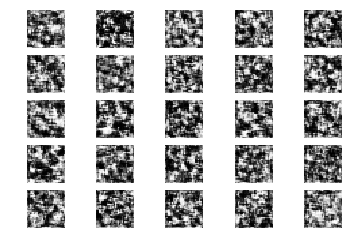

1 [D loss: 0.753041, acc.: 51.56%] [G loss: 1.000868]
2 [D loss: 0.687995, acc.: 60.94%] [G loss: 1.279048]
3 [D loss: 0.548055, acc.: 71.88%] [G loss: 1.137938]
4 [D loss: 0.435207, acc.: 79.69%] [G loss: 0.965316]
5 [D loss: 0.249119, acc.: 93.75%] [G loss: 0.918744]
6 [D loss: 0.353800, acc.: 82.81%] [G loss: 0.779997]
7 [D loss: 0.257868, acc.: 90.62%] [G loss: 0.537727]
8 [D loss: 0.311773, acc.: 89.06%] [G loss: 0.419520]
9 [D loss: 0.406225, acc.: 79.69%] [G loss: 0.625797]
10 [D loss: 0.480012, acc.: 76.56%] [G loss: 1.461621]
11 [D loss: 0.868281, acc.: 51.56%] [G loss: 1.713415]
12 [D loss: 0.699713, acc.: 60.94%] [G loss: 1.891610]
13 [D loss: 0.773343, acc.: 56.25%] [G loss: 2.025436]
14 [D loss: 0.634945, acc.: 70.31%] [G loss: 1.922551]
15 [D loss: 0.724581, acc.: 60.94%] [G loss: 1.760420]
16 [D loss: 0.708334, acc.: 60.94%] [G loss: 1.996330]
17 [D loss: 0.811231, acc.: 59.38%] [G loss: 1.455165]
18 [D loss: 0.569445, acc.: 75.00%] [G loss: 1.543611]
19 [D loss: 0.48657

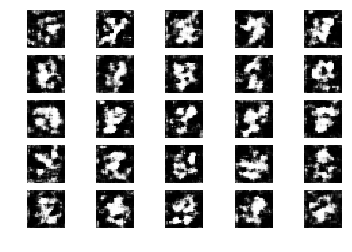

51 [D loss: 0.992186, acc.: 42.19%] [G loss: 1.379560]
52 [D loss: 0.841321, acc.: 45.31%] [G loss: 1.558193]
53 [D loss: 1.063971, acc.: 37.50%] [G loss: 1.617896]
54 [D loss: 1.006223, acc.: 43.75%] [G loss: 1.503320]
55 [D loss: 0.792914, acc.: 56.25%] [G loss: 1.638793]
56 [D loss: 0.835485, acc.: 51.56%] [G loss: 1.428347]
57 [D loss: 0.828545, acc.: 54.69%] [G loss: 1.143364]
58 [D loss: 0.773210, acc.: 65.62%] [G loss: 1.521749]
59 [D loss: 0.754369, acc.: 59.38%] [G loss: 1.157062]
60 [D loss: 0.622822, acc.: 67.19%] [G loss: 1.397261]
61 [D loss: 0.848316, acc.: 60.94%] [G loss: 1.313059]
62 [D loss: 0.977820, acc.: 42.19%] [G loss: 1.326685]
63 [D loss: 0.673930, acc.: 67.19%] [G loss: 1.596118]
64 [D loss: 0.827181, acc.: 50.00%] [G loss: 1.261902]
65 [D loss: 0.581275, acc.: 68.75%] [G loss: 1.329521]
66 [D loss: 0.735310, acc.: 50.00%] [G loss: 1.309484]
67 [D loss: 0.841041, acc.: 56.25%] [G loss: 1.230374]
68 [D loss: 0.849802, acc.: 51.56%] [G loss: 1.666441]
69 [D loss

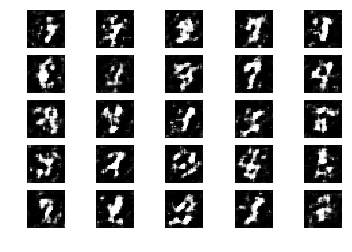

101 [D loss: 0.964222, acc.: 42.19%] [G loss: 1.302855]
102 [D loss: 0.982494, acc.: 34.38%] [G loss: 1.424415]
103 [D loss: 0.753527, acc.: 59.38%] [G loss: 1.371950]
104 [D loss: 0.918562, acc.: 42.19%] [G loss: 1.067239]
105 [D loss: 0.750112, acc.: 60.94%] [G loss: 1.134888]
106 [D loss: 0.892254, acc.: 50.00%] [G loss: 1.102164]
107 [D loss: 0.833423, acc.: 46.88%] [G loss: 1.163029]
108 [D loss: 0.882786, acc.: 46.88%] [G loss: 1.482482]
109 [D loss: 0.844260, acc.: 56.25%] [G loss: 1.000147]
110 [D loss: 0.936077, acc.: 43.75%] [G loss: 1.072905]
111 [D loss: 0.763421, acc.: 57.81%] [G loss: 0.840952]
112 [D loss: 1.016201, acc.: 40.62%] [G loss: 1.054425]
113 [D loss: 0.772766, acc.: 48.44%] [G loss: 1.564893]
114 [D loss: 0.897791, acc.: 42.19%] [G loss: 1.350134]
115 [D loss: 0.883475, acc.: 45.31%] [G loss: 1.126590]
116 [D loss: 0.729162, acc.: 60.94%] [G loss: 1.221678]
117 [D loss: 0.955946, acc.: 42.19%] [G loss: 1.290387]
118 [D loss: 0.790523, acc.: 50.00%] [G loss: 1.

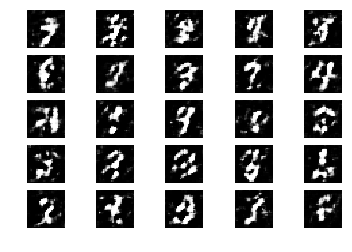

151 [D loss: 0.786191, acc.: 48.44%] [G loss: 1.164930]
152 [D loss: 0.820115, acc.: 50.00%] [G loss: 1.232019]
153 [D loss: 0.882560, acc.: 43.75%] [G loss: 1.140548]
154 [D loss: 0.914198, acc.: 35.94%] [G loss: 1.098528]
155 [D loss: 0.818527, acc.: 45.31%] [G loss: 1.438582]
156 [D loss: 0.812101, acc.: 53.12%] [G loss: 1.362761]
157 [D loss: 0.915213, acc.: 48.44%] [G loss: 0.968302]
158 [D loss: 0.786596, acc.: 45.31%] [G loss: 1.129127]
159 [D loss: 0.944509, acc.: 35.94%] [G loss: 0.992040]
160 [D loss: 0.754452, acc.: 64.06%] [G loss: 1.261168]
161 [D loss: 0.822681, acc.: 56.25%] [G loss: 1.357654]
162 [D loss: 0.861372, acc.: 37.50%] [G loss: 1.228358]
163 [D loss: 0.910811, acc.: 42.19%] [G loss: 1.105050]
164 [D loss: 0.912605, acc.: 35.94%] [G loss: 1.070091]
165 [D loss: 0.910747, acc.: 46.88%] [G loss: 0.928186]
166 [D loss: 0.861147, acc.: 45.31%] [G loss: 0.847530]
167 [D loss: 0.735680, acc.: 54.69%] [G loss: 1.231842]
168 [D loss: 0.865339, acc.: 43.75%] [G loss: 1.

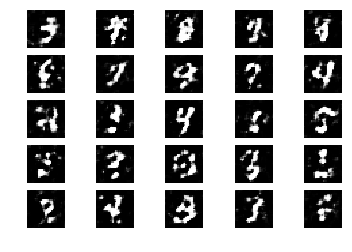

201 [D loss: 0.821798, acc.: 46.88%] [G loss: 0.989166]
202 [D loss: 0.847984, acc.: 50.00%] [G loss: 0.885078]
203 [D loss: 0.815030, acc.: 46.88%] [G loss: 1.390396]
204 [D loss: 0.806130, acc.: 46.88%] [G loss: 1.074371]
205 [D loss: 0.837201, acc.: 48.44%] [G loss: 1.161082]
206 [D loss: 0.929002, acc.: 43.75%] [G loss: 1.049290]
207 [D loss: 0.818122, acc.: 43.75%] [G loss: 1.287750]
208 [D loss: 0.808631, acc.: 46.88%] [G loss: 1.075031]
209 [D loss: 0.866897, acc.: 43.75%] [G loss: 1.194210]
210 [D loss: 0.708951, acc.: 54.69%] [G loss: 1.239920]
211 [D loss: 0.745312, acc.: 54.69%] [G loss: 1.210478]
212 [D loss: 0.977606, acc.: 37.50%] [G loss: 1.041370]
213 [D loss: 0.806181, acc.: 48.44%] [G loss: 1.109689]
214 [D loss: 0.889687, acc.: 42.19%] [G loss: 1.069396]
215 [D loss: 0.767095, acc.: 54.69%] [G loss: 0.946793]
216 [D loss: 0.874075, acc.: 42.19%] [G loss: 1.151727]
217 [D loss: 0.862445, acc.: 45.31%] [G loss: 1.136220]
218 [D loss: 0.824856, acc.: 46.88%] [G loss: 1.

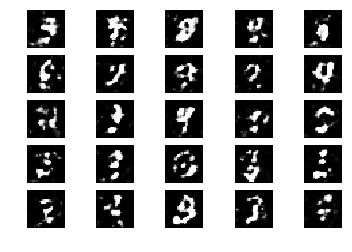

251 [D loss: 0.785145, acc.: 54.69%] [G loss: 0.962760]
252 [D loss: 0.642944, acc.: 64.06%] [G loss: 1.222508]
253 [D loss: 0.891447, acc.: 32.81%] [G loss: 1.238147]
254 [D loss: 0.777593, acc.: 48.44%] [G loss: 1.088456]
255 [D loss: 0.864462, acc.: 45.31%] [G loss: 1.144802]
256 [D loss: 0.791883, acc.: 53.12%] [G loss: 0.972907]
257 [D loss: 0.786229, acc.: 53.12%] [G loss: 1.008322]
258 [D loss: 0.792301, acc.: 51.56%] [G loss: 0.942620]
259 [D loss: 0.654958, acc.: 54.69%] [G loss: 1.271013]
260 [D loss: 0.840826, acc.: 40.62%] [G loss: 0.836314]
261 [D loss: 0.694017, acc.: 56.25%] [G loss: 1.045691]
262 [D loss: 0.875539, acc.: 37.50%] [G loss: 1.041006]
263 [D loss: 0.845511, acc.: 43.75%] [G loss: 0.853202]
264 [D loss: 0.693253, acc.: 62.50%] [G loss: 1.132195]
265 [D loss: 0.750741, acc.: 51.56%] [G loss: 1.008342]
266 [D loss: 0.755027, acc.: 48.44%] [G loss: 1.205144]
267 [D loss: 0.694194, acc.: 51.56%] [G loss: 0.885227]
268 [D loss: 0.855499, acc.: 42.19%] [G loss: 1.

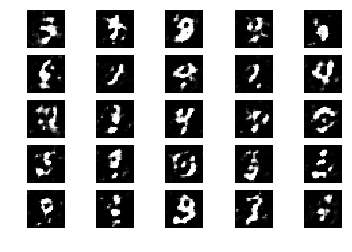

301 [D loss: 0.735731, acc.: 60.94%] [G loss: 1.031520]
302 [D loss: 0.757348, acc.: 50.00%] [G loss: 1.066977]
303 [D loss: 0.753374, acc.: 51.56%] [G loss: 1.091119]
304 [D loss: 0.684348, acc.: 62.50%] [G loss: 1.028913]
305 [D loss: 0.673756, acc.: 59.38%] [G loss: 0.968125]
306 [D loss: 0.707441, acc.: 53.12%] [G loss: 1.096597]
307 [D loss: 0.785746, acc.: 42.19%] [G loss: 1.083062]
308 [D loss: 0.778890, acc.: 53.12%] [G loss: 1.104480]
309 [D loss: 0.963070, acc.: 35.94%] [G loss: 0.930314]
310 [D loss: 0.678706, acc.: 59.38%] [G loss: 1.021245]
311 [D loss: 0.736048, acc.: 60.94%] [G loss: 0.930708]
312 [D loss: 0.763064, acc.: 51.56%] [G loss: 0.847799]
313 [D loss: 0.729711, acc.: 54.69%] [G loss: 0.962577]
314 [D loss: 0.737672, acc.: 56.25%] [G loss: 1.216485]
315 [D loss: 0.719558, acc.: 53.12%] [G loss: 0.786227]
316 [D loss: 0.813724, acc.: 50.00%] [G loss: 1.079010]
317 [D loss: 0.724696, acc.: 50.00%] [G loss: 0.919688]
318 [D loss: 0.761220, acc.: 54.69%] [G loss: 0.

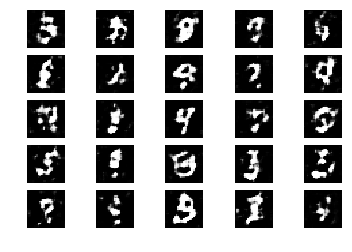

351 [D loss: 0.818325, acc.: 56.25%] [G loss: 1.065505]
352 [D loss: 0.790684, acc.: 51.56%] [G loss: 1.085889]
353 [D loss: 0.687865, acc.: 60.94%] [G loss: 1.201103]
354 [D loss: 0.729406, acc.: 56.25%] [G loss: 1.058995]
355 [D loss: 0.800962, acc.: 51.56%] [G loss: 1.170974]
356 [D loss: 0.690030, acc.: 56.25%] [G loss: 1.104276]
357 [D loss: 0.789522, acc.: 53.12%] [G loss: 0.984833]
358 [D loss: 0.782851, acc.: 50.00%] [G loss: 1.188765]
359 [D loss: 0.939866, acc.: 40.62%] [G loss: 1.154180]
360 [D loss: 0.790164, acc.: 53.12%] [G loss: 0.914481]
361 [D loss: 0.859296, acc.: 51.56%] [G loss: 1.161338]
362 [D loss: 0.772984, acc.: 59.38%] [G loss: 1.238967]
363 [D loss: 0.809490, acc.: 48.44%] [G loss: 0.910979]
364 [D loss: 0.686023, acc.: 57.81%] [G loss: 1.077710]
365 [D loss: 0.769529, acc.: 53.12%] [G loss: 0.886191]
366 [D loss: 0.722825, acc.: 54.69%] [G loss: 0.863797]
367 [D loss: 0.849760, acc.: 46.88%] [G loss: 0.827180]
368 [D loss: 0.693246, acc.: 54.69%] [G loss: 0.

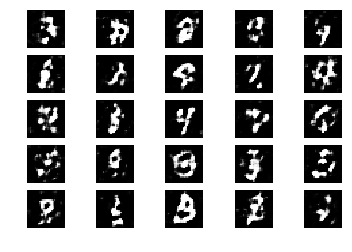

401 [D loss: 0.793887, acc.: 56.25%] [G loss: 1.055119]
402 [D loss: 0.711239, acc.: 59.38%] [G loss: 0.969890]
403 [D loss: 0.742142, acc.: 56.25%] [G loss: 1.059653]
404 [D loss: 0.791715, acc.: 42.19%] [G loss: 1.011220]
405 [D loss: 0.817789, acc.: 39.06%] [G loss: 0.957603]
406 [D loss: 0.764528, acc.: 53.12%] [G loss: 1.081148]
407 [D loss: 0.692288, acc.: 65.62%] [G loss: 0.929313]
408 [D loss: 0.669141, acc.: 59.38%] [G loss: 1.071977]
409 [D loss: 0.770089, acc.: 54.69%] [G loss: 1.006326]
410 [D loss: 0.767689, acc.: 42.19%] [G loss: 1.221199]
411 [D loss: 0.810006, acc.: 53.12%] [G loss: 1.145738]
412 [D loss: 0.704358, acc.: 59.38%] [G loss: 0.990078]
413 [D loss: 0.717370, acc.: 54.69%] [G loss: 1.055315]
414 [D loss: 0.675358, acc.: 60.94%] [G loss: 1.045262]
415 [D loss: 0.735765, acc.: 53.12%] [G loss: 0.938545]
416 [D loss: 0.731309, acc.: 51.56%] [G loss: 1.008893]
417 [D loss: 0.782717, acc.: 50.00%] [G loss: 0.818231]
418 [D loss: 0.761317, acc.: 46.88%] [G loss: 0.

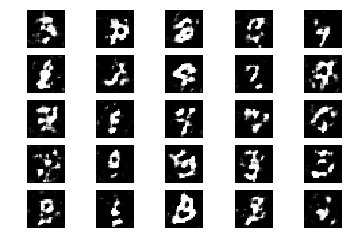

451 [D loss: 0.848371, acc.: 45.31%] [G loss: 1.027497]
452 [D loss: 0.717041, acc.: 56.25%] [G loss: 0.872532]
453 [D loss: 0.825876, acc.: 45.31%] [G loss: 0.991151]
454 [D loss: 0.786771, acc.: 53.12%] [G loss: 1.014789]
455 [D loss: 0.761685, acc.: 53.12%] [G loss: 1.082903]
456 [D loss: 0.683427, acc.: 64.06%] [G loss: 1.119629]
457 [D loss: 0.712305, acc.: 51.56%] [G loss: 1.123353]
458 [D loss: 0.851349, acc.: 53.12%] [G loss: 0.977636]
459 [D loss: 0.825954, acc.: 46.88%] [G loss: 0.774597]
460 [D loss: 0.831146, acc.: 43.75%] [G loss: 0.965358]
461 [D loss: 0.735021, acc.: 54.69%] [G loss: 1.001890]
462 [D loss: 0.785140, acc.: 48.44%] [G loss: 1.080505]
463 [D loss: 0.699054, acc.: 54.69%] [G loss: 1.032390]
464 [D loss: 0.674593, acc.: 59.38%] [G loss: 1.092854]
465 [D loss: 0.743896, acc.: 54.69%] [G loss: 1.020602]
466 [D loss: 0.760208, acc.: 54.69%] [G loss: 1.105006]
467 [D loss: 0.673949, acc.: 54.69%] [G loss: 0.822526]
468 [D loss: 0.758672, acc.: 48.44%] [G loss: 0.

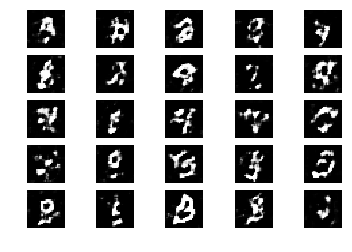

501 [D loss: 0.736606, acc.: 54.69%] [G loss: 0.932096]
502 [D loss: 0.870492, acc.: 39.06%] [G loss: 0.917661]
503 [D loss: 0.814601, acc.: 45.31%] [G loss: 1.014002]
504 [D loss: 0.718710, acc.: 54.69%] [G loss: 1.070053]
505 [D loss: 0.679212, acc.: 54.69%] [G loss: 1.163245]
506 [D loss: 0.765045, acc.: 46.88%] [G loss: 1.224630]
507 [D loss: 0.845847, acc.: 45.31%] [G loss: 1.103928]
508 [D loss: 0.776377, acc.: 50.00%] [G loss: 1.158410]
509 [D loss: 0.772692, acc.: 46.88%] [G loss: 1.158753]
510 [D loss: 0.657388, acc.: 60.94%] [G loss: 1.055522]
511 [D loss: 0.701942, acc.: 57.81%] [G loss: 1.083305]
512 [D loss: 0.746118, acc.: 53.12%] [G loss: 0.923101]
513 [D loss: 0.889850, acc.: 45.31%] [G loss: 0.923306]
514 [D loss: 0.686422, acc.: 57.81%] [G loss: 1.171340]
515 [D loss: 0.910253, acc.: 34.38%] [G loss: 0.902434]
516 [D loss: 0.718769, acc.: 56.25%] [G loss: 0.935403]
517 [D loss: 0.735777, acc.: 56.25%] [G loss: 0.839241]
518 [D loss: 0.680520, acc.: 62.50%] [G loss: 1.

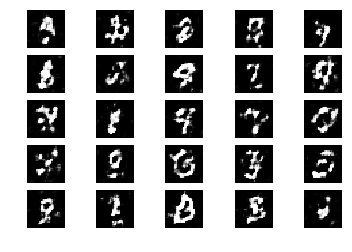

551 [D loss: 0.708313, acc.: 51.56%] [G loss: 1.182824]
552 [D loss: 0.812072, acc.: 48.44%] [G loss: 1.016204]
553 [D loss: 0.723846, acc.: 51.56%] [G loss: 1.029956]
554 [D loss: 0.670404, acc.: 56.25%] [G loss: 1.145438]
555 [D loss: 0.770558, acc.: 51.56%] [G loss: 0.949731]
556 [D loss: 0.678288, acc.: 60.94%] [G loss: 1.028760]
557 [D loss: 0.661936, acc.: 59.38%] [G loss: 1.090207]
558 [D loss: 0.769022, acc.: 51.56%] [G loss: 1.039666]
559 [D loss: 0.849325, acc.: 39.06%] [G loss: 0.951160]
560 [D loss: 0.768019, acc.: 51.56%] [G loss: 0.925762]
561 [D loss: 0.700311, acc.: 54.69%] [G loss: 0.955269]
562 [D loss: 0.808091, acc.: 46.88%] [G loss: 0.904379]
563 [D loss: 0.708559, acc.: 53.12%] [G loss: 0.955038]
564 [D loss: 0.807099, acc.: 42.19%] [G loss: 0.995414]
565 [D loss: 0.676893, acc.: 57.81%] [G loss: 0.893523]
566 [D loss: 0.744476, acc.: 59.38%] [G loss: 1.059494]
567 [D loss: 0.723482, acc.: 54.69%] [G loss: 0.989522]
568 [D loss: 0.755623, acc.: 57.81%] [G loss: 0.

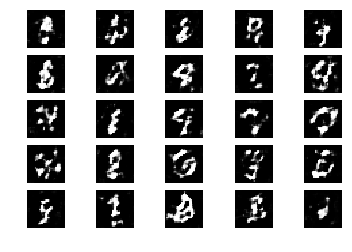

601 [D loss: 0.828076, acc.: 43.75%] [G loss: 1.060996]
602 [D loss: 0.732366, acc.: 57.81%] [G loss: 1.185401]
603 [D loss: 0.752082, acc.: 45.31%] [G loss: 1.132511]
604 [D loss: 0.772727, acc.: 54.69%] [G loss: 0.958139]
605 [D loss: 0.800695, acc.: 53.12%] [G loss: 1.156138]
606 [D loss: 0.687745, acc.: 57.81%] [G loss: 0.979205]
607 [D loss: 0.691795, acc.: 46.88%] [G loss: 0.937186]
608 [D loss: 0.719671, acc.: 53.12%] [G loss: 1.250492]
609 [D loss: 0.740946, acc.: 56.25%] [G loss: 1.033128]
610 [D loss: 0.648020, acc.: 67.19%] [G loss: 1.061118]
611 [D loss: 0.716344, acc.: 54.69%] [G loss: 1.220425]
612 [D loss: 0.712094, acc.: 51.56%] [G loss: 1.062129]
613 [D loss: 0.727339, acc.: 53.12%] [G loss: 1.011856]
614 [D loss: 0.746665, acc.: 54.69%] [G loss: 0.979316]
615 [D loss: 0.716468, acc.: 50.00%] [G loss: 0.969789]
616 [D loss: 0.771703, acc.: 50.00%] [G loss: 0.993995]
617 [D loss: 0.661972, acc.: 53.12%] [G loss: 1.061117]
618 [D loss: 0.735895, acc.: 56.25%] [G loss: 1.

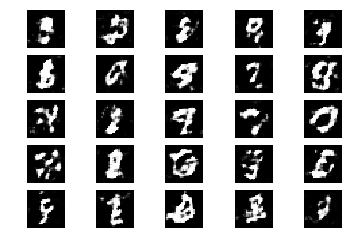

651 [D loss: 0.669644, acc.: 53.12%] [G loss: 1.189952]
652 [D loss: 0.710308, acc.: 57.81%] [G loss: 1.200368]
653 [D loss: 0.755961, acc.: 53.12%] [G loss: 1.112531]
654 [D loss: 0.664345, acc.: 59.38%] [G loss: 1.093397]
655 [D loss: 0.721887, acc.: 51.56%] [G loss: 1.088558]
656 [D loss: 0.755226, acc.: 46.88%] [G loss: 1.001737]
657 [D loss: 0.743893, acc.: 53.12%] [G loss: 1.122676]
658 [D loss: 0.778010, acc.: 51.56%] [G loss: 1.026709]
659 [D loss: 0.738973, acc.: 56.25%] [G loss: 1.020257]
660 [D loss: 0.809574, acc.: 45.31%] [G loss: 0.996881]
661 [D loss: 0.715786, acc.: 53.12%] [G loss: 1.002587]
662 [D loss: 0.680909, acc.: 57.81%] [G loss: 1.124034]
663 [D loss: 0.666766, acc.: 59.38%] [G loss: 1.096421]
664 [D loss: 0.699488, acc.: 54.69%] [G loss: 0.917793]
665 [D loss: 0.693500, acc.: 57.81%] [G loss: 0.945459]
666 [D loss: 0.716133, acc.: 54.69%] [G loss: 0.965678]
667 [D loss: 0.681540, acc.: 53.12%] [G loss: 0.997654]
668 [D loss: 0.794221, acc.: 56.25%] [G loss: 1.

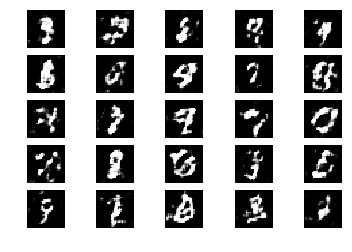

701 [D loss: 0.675243, acc.: 54.69%] [G loss: 1.166183]
702 [D loss: 0.769670, acc.: 54.69%] [G loss: 1.011224]
703 [D loss: 0.664817, acc.: 59.38%] [G loss: 1.089418]
704 [D loss: 0.682929, acc.: 56.25%] [G loss: 1.102425]
705 [D loss: 0.652713, acc.: 65.62%] [G loss: 1.044344]
706 [D loss: 0.725976, acc.: 51.56%] [G loss: 1.043196]
707 [D loss: 0.761263, acc.: 54.69%] [G loss: 0.792464]
708 [D loss: 0.686967, acc.: 60.94%] [G loss: 1.016456]
709 [D loss: 0.711948, acc.: 54.69%] [G loss: 1.074347]
710 [D loss: 0.671735, acc.: 65.62%] [G loss: 1.147152]
711 [D loss: 0.723047, acc.: 54.69%] [G loss: 1.087497]
712 [D loss: 0.815498, acc.: 42.19%] [G loss: 1.072399]
713 [D loss: 0.741945, acc.: 56.25%] [G loss: 0.897405]
714 [D loss: 0.649219, acc.: 67.19%] [G loss: 1.017153]
715 [D loss: 0.814734, acc.: 45.31%] [G loss: 1.053022]
716 [D loss: 0.734730, acc.: 51.56%] [G loss: 1.125216]
717 [D loss: 0.666110, acc.: 57.81%] [G loss: 1.065355]
718 [D loss: 0.707124, acc.: 54.69%] [G loss: 1.

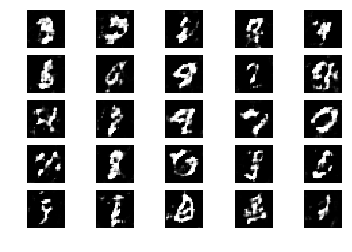

751 [D loss: 0.616743, acc.: 64.06%] [G loss: 1.060490]
752 [D loss: 0.694501, acc.: 56.25%] [G loss: 0.978853]
753 [D loss: 0.680070, acc.: 53.12%] [G loss: 1.090037]
754 [D loss: 0.630504, acc.: 57.81%] [G loss: 1.085371]
755 [D loss: 0.763609, acc.: 56.25%] [G loss: 1.026332]
756 [D loss: 0.685167, acc.: 53.12%] [G loss: 1.241611]
757 [D loss: 0.708723, acc.: 59.38%] [G loss: 1.125235]
758 [D loss: 0.683645, acc.: 56.25%] [G loss: 1.021319]
759 [D loss: 0.676610, acc.: 56.25%] [G loss: 0.929332]
760 [D loss: 0.707293, acc.: 53.12%] [G loss: 1.006331]
761 [D loss: 0.646135, acc.: 65.62%] [G loss: 1.206508]
762 [D loss: 0.705744, acc.: 54.69%] [G loss: 0.909648]
763 [D loss: 0.703009, acc.: 59.38%] [G loss: 0.806366]
764 [D loss: 0.614494, acc.: 68.75%] [G loss: 1.021396]
765 [D loss: 0.713750, acc.: 57.81%] [G loss: 1.157043]
766 [D loss: 0.803966, acc.: 48.44%] [G loss: 1.119045]
767 [D loss: 0.793703, acc.: 46.88%] [G loss: 0.950900]
768 [D loss: 0.686784, acc.: 64.06%] [G loss: 0.

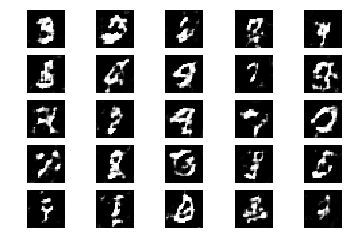

801 [D loss: 0.774390, acc.: 62.50%] [G loss: 0.983327]
802 [D loss: 0.776253, acc.: 51.56%] [G loss: 1.132035]
803 [D loss: 0.746580, acc.: 48.44%] [G loss: 1.125768]
804 [D loss: 0.818384, acc.: 45.31%] [G loss: 0.828804]
805 [D loss: 0.728606, acc.: 53.12%] [G loss: 0.941886]
806 [D loss: 0.773089, acc.: 48.44%] [G loss: 0.999611]
807 [D loss: 0.785809, acc.: 46.88%] [G loss: 0.929538]
808 [D loss: 0.638495, acc.: 60.94%] [G loss: 1.120332]
809 [D loss: 0.643190, acc.: 64.06%] [G loss: 0.974323]
810 [D loss: 0.746100, acc.: 48.44%] [G loss: 0.993485]
811 [D loss: 0.687255, acc.: 53.12%] [G loss: 1.012946]
812 [D loss: 0.711021, acc.: 53.12%] [G loss: 1.114080]
813 [D loss: 0.691262, acc.: 59.38%] [G loss: 0.964096]
814 [D loss: 0.751751, acc.: 54.69%] [G loss: 1.060952]
815 [D loss: 0.747677, acc.: 50.00%] [G loss: 1.049948]
816 [D loss: 0.727623, acc.: 57.81%] [G loss: 1.054066]
817 [D loss: 0.692453, acc.: 51.56%] [G loss: 1.244648]
818 [D loss: 0.744738, acc.: 46.88%] [G loss: 1.

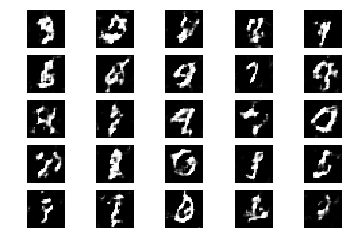

851 [D loss: 0.613962, acc.: 67.19%] [G loss: 1.242873]
852 [D loss: 0.743070, acc.: 59.38%] [G loss: 1.065563]
853 [D loss: 0.674716, acc.: 57.81%] [G loss: 1.052081]
854 [D loss: 0.748605, acc.: 51.56%] [G loss: 0.982263]
855 [D loss: 0.810527, acc.: 48.44%] [G loss: 1.022593]
856 [D loss: 0.681245, acc.: 59.38%] [G loss: 0.994331]
857 [D loss: 0.798808, acc.: 45.31%] [G loss: 1.135312]
858 [D loss: 0.645840, acc.: 67.19%] [G loss: 1.151108]
859 [D loss: 0.687351, acc.: 60.94%] [G loss: 0.956595]
860 [D loss: 0.751291, acc.: 56.25%] [G loss: 1.059576]
861 [D loss: 0.668245, acc.: 57.81%] [G loss: 1.183255]
862 [D loss: 0.716206, acc.: 59.38%] [G loss: 1.146243]
863 [D loss: 0.850492, acc.: 45.31%] [G loss: 0.829484]
864 [D loss: 0.770942, acc.: 48.44%] [G loss: 0.926773]
865 [D loss: 0.647914, acc.: 64.06%] [G loss: 0.984097]
866 [D loss: 0.752726, acc.: 50.00%] [G loss: 0.978931]
867 [D loss: 0.702838, acc.: 56.25%] [G loss: 0.990079]
868 [D loss: 0.703570, acc.: 59.38%] [G loss: 0.

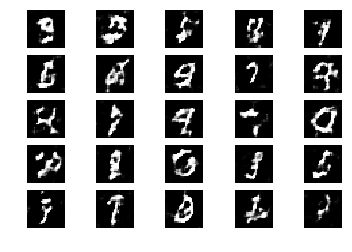

901 [D loss: 0.628247, acc.: 60.94%] [G loss: 1.095203]
902 [D loss: 0.623002, acc.: 64.06%] [G loss: 1.000862]
903 [D loss: 0.665343, acc.: 59.38%] [G loss: 1.004516]
904 [D loss: 0.694427, acc.: 59.38%] [G loss: 0.967552]
905 [D loss: 0.655771, acc.: 57.81%] [G loss: 1.159898]
906 [D loss: 0.687715, acc.: 60.94%] [G loss: 1.164256]
907 [D loss: 0.697084, acc.: 56.25%] [G loss: 1.077214]
908 [D loss: 0.852870, acc.: 48.44%] [G loss: 1.147561]
909 [D loss: 0.693726, acc.: 54.69%] [G loss: 1.190682]
910 [D loss: 0.714680, acc.: 51.56%] [G loss: 1.110103]
911 [D loss: 0.760370, acc.: 45.31%] [G loss: 0.993979]
912 [D loss: 0.700645, acc.: 50.00%] [G loss: 1.011300]
913 [D loss: 0.746701, acc.: 48.44%] [G loss: 1.003859]
914 [D loss: 0.816284, acc.: 42.19%] [G loss: 0.808180]
915 [D loss: 0.649597, acc.: 68.75%] [G loss: 1.054600]
916 [D loss: 0.795520, acc.: 43.75%] [G loss: 0.943186]
917 [D loss: 0.709682, acc.: 56.25%] [G loss: 1.064255]
918 [D loss: 0.817431, acc.: 50.00%] [G loss: 0.

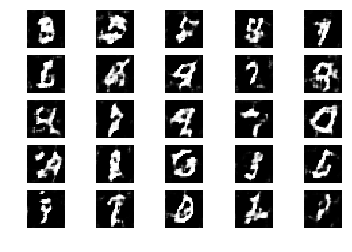

951 [D loss: 0.667913, acc.: 60.94%] [G loss: 1.000145]
952 [D loss: 0.662450, acc.: 59.38%] [G loss: 1.158547]
953 [D loss: 0.665271, acc.: 57.81%] [G loss: 1.077142]
954 [D loss: 0.850161, acc.: 45.31%] [G loss: 1.201866]
955 [D loss: 0.716622, acc.: 56.25%] [G loss: 1.140390]
956 [D loss: 0.718404, acc.: 57.81%] [G loss: 1.073652]
957 [D loss: 0.807505, acc.: 53.12%] [G loss: 0.912228]
958 [D loss: 0.675729, acc.: 62.50%] [G loss: 1.033600]
959 [D loss: 0.691730, acc.: 53.12%] [G loss: 0.994112]
960 [D loss: 0.734720, acc.: 56.25%] [G loss: 1.057335]
961 [D loss: 0.712000, acc.: 54.69%] [G loss: 0.848157]
962 [D loss: 0.643731, acc.: 67.19%] [G loss: 0.985683]
963 [D loss: 0.689656, acc.: 54.69%] [G loss: 1.077576]
964 [D loss: 0.651377, acc.: 62.50%] [G loss: 1.194946]
965 [D loss: 0.679229, acc.: 54.69%] [G loss: 1.071441]
966 [D loss: 0.637531, acc.: 62.50%] [G loss: 1.009656]
967 [D loss: 0.716571, acc.: 57.81%] [G loss: 1.159041]
968 [D loss: 0.685665, acc.: 62.50%] [G loss: 1.

KeyboardInterrupt: 

In [2]:
train(epochs=4000, batch_size=32, save_interval=50)

## Recovery of latent vector

Generator는 latent vector를 입력받아 이미지를 생성한다. img : z -> G(z)<br>
하지만, Generator는 이미지로부터 latent vector를 찾는 inverse mapping은 성립하지 않는다. <br>
<br>
아래코드는 이미지로부터 근사치의 latent vector를 찾는 코드이다. G(z) -> z

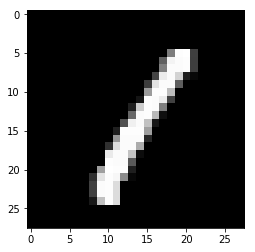

In [6]:
#원본 이미지
plt.imshow(X_train[3].reshape(28, 28), cmap='gray')

In [7]:
#원본이미지와 가장 비슷한 이미지를 생성하는 Latent Vector를 찾는다.
r_input = Input(shape=(10,))
g_input = Dense((100), trainable=True)(r_input)
g_input = Activation('sigmoid',name='latent_vector')(g_input)
generator.trainable = False

predict_img = generator(g_input)
model = Model(r_input, predict_img)
model.compile(loss='mean_squared_error', optimizer='rmsprop')

z = np.random.uniform(0, 1, size=(1, 10))
loss = model.fit(z, X_train[3].reshape(1, 28, 28, 1), batch_size=1, epochs=1000, verbose=0)

latent_vector_model = Model(r_input, model.get_layer('latent_vector').output)
latent_vector = latent_vector_model.predict(z)


#찾은 latent_vector 출력
print(latent_vector)

[[ 0.80164123  0.83572316  0.32884011  0.02036711  0.99101907  0.65710741
   0.96982175  0.74783444  0.78620923  0.03661965  0.21116063  0.98923498
   0.20420937  0.5840469   0.91152936  0.01545538  0.03504249  0.98849458
   0.36565468  0.16759737  0.16711879  0.6822924   0.04059614  0.71002036
   0.03640335  0.71720415  0.09916218  0.9818334   0.09571362  0.93153411
   0.97812527  0.13793281  0.44333813  0.00899079  0.12799351  0.0489887
   0.02573426  0.24572359  0.0175634   0.00802836  0.07849803  0.01463306
   0.02961688  0.26094407  0.4382      0.00834768  0.41209996  0.96949869
   0.44441515  0.6492852   0.65815902  0.03416197  0.04172052  0.79445475
   0.07602606  0.07071339  0.10761819  0.06564423  0.92711049  0.01194626
   0.06254561  0.01045515  0.42039505  0.19449805  0.07788898  0.1243358
   0.00924126  0.01379745  0.09936634  0.7187503   0.67170531  0.01355275
   0.01565249  0.61757803  0.84112012  0.41218841  0.05032707  0.07620197
   0.02895419  0.11412039  0.01188613  0

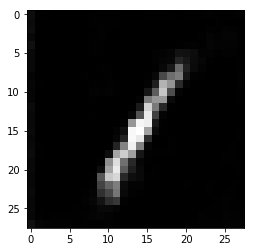

In [8]:
#찾은 이미지 출력
img = generator.predict(latent_vector)
plt.imshow(img.reshape(28, 28), cmap='gray')

## Interpolation

![alt text](img/4.PNG "Title")

2개의 이미지를 정하고 이미지로부터 latent vetor를 찾아서 Interpolation 구현해보기. <br>

관련설명 : https://www.samsungsds.com/global/ko/support/insights/Generative-adversarial-network-AI-2.html
